In [ ]:
%matplotlib inline


# Neural Style Transfer (NST) на PyTorch


## Введение

В ходе этого упражнения мы воплотим алгоритм [Neural-Style algorithm](https://arxiv.org/abs/1508.06576), разработанный Leon A. Gatys, Alexander S. Ecker и Matthias Bethge.

Neural-Style или Neural-Transfer позволяет преобразовать изображение, применив к нему стиль с другого изображения. Всего алгоритму нужно три изображения: "отправное", "контент" и "стиль". В ходе работы алгоритм видоизменяет отправное изображение таким образом, чтобы его содержимое было похоже на то, что изображено на изображении "контент", но графический стиль изображения был бы похож на стиль последнего изображения в связке.

# Домашнее задание

- [ ] Установите размер изображения равным 512
- [ ] Замените нейросеть на VGG-16
- [ ] Поменяйте вес вклада стиля и контента, в общую лосс-функцию (например, на 1000 к 1)
- [ ] Сгенерируйте собственное NST изображение для выбранных вами входных, контент- и стилевых изображений

## Шаблонный код, загружаем нейросеть и выбираем вычислитель

Какие библиотеки нам понадобятся:

-  ``torch``, ``torch.nn``, ``numpy`` (необходимы для работы с нейросетями через PyTorch)
-  ``torch.optim`` (хорошие процедуры оптимизации)
-  ``PIL``, ``PIL.Image``, ``matplotlib.pyplot`` (загрузка и отображение картинок)
-  ``torchvision.transforms`` (чтобы автоматизировать преобразование изображений)
-  ``torchvision.models`` (здесь у нас предобученные модели)
-  ``copy`` (системная библиотека чтобы создавать копии объектов, а то python не любит двойную работу...)

In [1]:
!pip install torchvision

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

Дальше, нужно указать, на каком вычислительном устройстве будет выполняться нейросеть и вся процедура оптимизации. Если вы выберете больший размер изображений, процедуре потребуется больше времени.

Функция ``torch.cuda.is_available()`` позволяет узнать, есть ли в системе графическая карта (GPU). Затем мы при помощи ``torch.device`` укажем, на каком устройстве будут производиться вычисления по умолчанию, и будем пользоваться командой ``.to(device)`` чтобы переносить модули нейросети или матрицы (тензоры) в память нужного устройства.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [4]:
device

device(type='cpu')

## Загружаем изображения

Здесь мы загрузим Стиль и Контент (два изображения). При загрузке через библиотеку PIL, значение каждого пикселя находится  в диапазоне между 0 и 255. Потом мы переведем значения в диапазон от 0 до 1, масштабируем изображения до одного размера, заодно обрежем их до квадрата.

Если подать на вход нейросети матрицу с значениями от 0 до 255, нейросеть тоже обработает эту информацию, но эмбеддинги не будут отражать то, чему нейросеть смогла научиться на исходном датасете. Скорее всего, сеть не распознает содержимое и стиль так, как мы ожидаем.

В одной из версий демонстрации мы используем следующие изображения:
[picasso.jpg](https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg) и
[dancing.jpg](https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg), но вы можете взять любые две картинки, например [что-нибудь абстрактное](https://unsplash.com/s/photos/abstract) из **unsplash**. Их нужно разместить в папке ``data/images`` в текущей директории (если вы работаете в Colab, по умолчанию это – директория ``content``).



In [36]:
# Какого размера изображения мы хотим обрабатывать
imsize =  512  # Если нет GPU, делаем изображение поменьше

loader = transforms.Compose([
    transforms.Resize(imsize),  # масштабируем с сохранением соотношения сторон
    transforms.CenterCrop(imsize), # обрежем края чтобы получить квадратное изображение
    transforms.ToTensor()])  # преобразуем в нужный нам класс – Torch Tensor


def image_loader(image_name):
    # Загрузим и преобразуем картинку, вдруг она в оттенках серого или с альфа-каналом...
    image = Image.open(image_name).convert('RGB')
    # нейросеть ждет не просто картинку, а набор картинок
    # поэтому мы добавим к изображению одно мнимое измерение
    # (количество картинок в батче всегда будет равно 1)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./data/images/vkontakte-39.jpg")
content_img = image_loader("./data/images/content.jpg")

assert style_img.size() == content_img.size(), \
    "Изображения должны быть одинакового размера, что-то пропущено в процедуре подготовки изображений"

Теперь создаем функцию, которая преобразует рабочую копию изображения обратно в PIL формат и отображает картинку при помощи ``plt.imshow``. И сразу используем ее чтобы вывести изображения – Стиль и Контент.

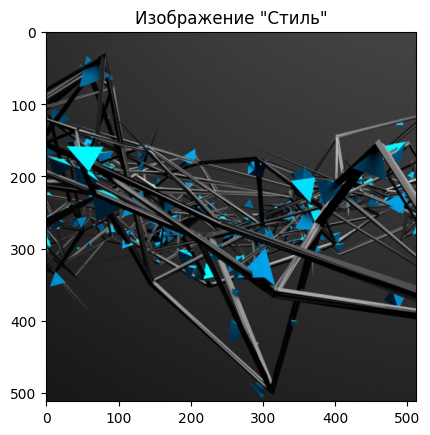

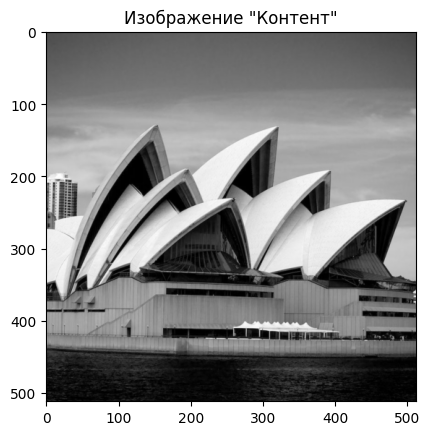

In [37]:
unloader = transforms.ToPILImage()  # Преобразуем в картинку PIL

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # создаем копию тензора чтобы не менять исходный
    image = image.squeeze(0)      # устраняем лишнее измерение (которое делало батч из изображения)
    image = unloader(image)
    plt.imshow(image)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # Дадим графику обновиться

plt.figure()
imshow(style_img, title='Изображение "Стиль"')

plt.figure()
imshow(content_img, title='Изображение "Контент"')

## Критерии оптимизации (лосс-функции)

### Расхождение по контенту (Content loss)

Итак, нам нужно реализовать функцию, которая измеряет расстояние между двумя изображениями в части содержимого изображений. На входе будет отдельный слой, для которого мы хотим посчитать лосс – набор карт признаков $F_{XL}$ слоя $L$. Нейросеть будет обрабатывать входной объект $X$ и возвращать косинусное расстояние $w_{CL}.D_C^L(X,C)$ (косинусный коэффициент, коэффициент Отиаи...) между входной картинкой $X$ и картинкой $C$, из которой мы берем контент. карты признаков целевого изображения по контенту ($F_{CL}$) тоже нужно будет передать в функцию.

Это простое скалярное произведение ($\sum_{i=1}^{n}{A_i B_i}$) разделенное на произведение мер всех сравниваемых объектов ($\sqrt{\sum_{i=1}^{n}{A_i^2}} \cdot \sqrt{\sum_{i=1}^{n}{B_i^2}}$).

Рассчитывать эту метрику будет объект типа Torch Module, его конструктор принимает на вход $F_{CL}$. Расстояние $\|F_{XL} - F_{CL}\|^2$ – это среднеквадратическое отклонение между наборами карт признаков, которое мы рассчитаем при помощи ``nn.MSELoss``.

Этот модуль встает сразу после какого-нибудь из слоев нейросети, по которому мы будем считать расхождение по контенту. Каждый раз когда нейросеть получит на вход новое изображение (его новую итерацию), на нужных нам слоях произведутся вычисления нужных нам метрик, а благодаря автоматическому дифференцированию, мы заодно получим и градиент ошибки. Чтобы слой не только считал метрику, но и передавал информацию дальше по нейросети, нужно определить метод ``forward``, который будет считать расстояние, а затем просто передавать входной набор признаков – на выход. Метрику мы получим как один из доступных параметров модуля.

In [38]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # нуно "отвязать" (detach) набор целевых признаков (target content)
        # от других объектов, которые находят его градиент. Это статический объект
        # Если этого не сделать, метод forward вернут нам ошибку
        self.target = target.detach()
    
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    

Хотя модуль и называется ``ContentLoss``, он на самом деле не является настоящей лосс-функцией по всем правилам PyTorch. Ему не хватает функции  ``backward``, чтобы подсказать PyTorch, как производить автоматическое дифференцирование. Но мы не будем обучать эту нейросеть и ``backward`` не понадобится.

### Расхождение по стилю (Style Loss)

Модуль расчета близости по стилю реализован схожим образом с модулем, который рассчитывает близость по контенту.

Это прозрачный слой внутри нейросети, который находит лосс-функцию по стилю между входным изображением и шаблоном. Сперва нужно рассчитать матрицу Грама $G_{XL}$. Сама матрица Грама получается перемножением матрицы на ее транспонированный вариант. Конкретно в нашем случае, входной матрицей будет являться матрица карт $F_{XL}$ на слое $L$.

Мы изменим размерность $F_{XL}$ так, чтобы преобразованная матрица $\hat{F}_{XL}$ имела размерность $K$\ x\ $N$, где $K$ – количество признаковых описаний на слое $L$, а $N$ – длина отдельно взятой матрицы $F_{XL}^k$, если ее растянуть в вектор. 

Например, первая линия полученной матрицы $\hat{F}_{XL}$ – это вытянутая в один вектор первая по счету карта признаков $F_{XL}^1$.

В конце концов нужно будет нормализовать матрицу Грама, что мы сделаем, разделив ее значения на суммарное количество элементов. Это позволит нам обойти ту проблему, при которой признаковые матрицы $\hat{F}_{XL}$ на более ранних слоях, где они еще сохраняют большой размер (высокое значение $N$) будут иметь большие значения матрицы Грама. В свою очередь, этот дисбаланс (более крупные значения у входных слоев) приведет к тому, что более ранние слои (до пулингов, которые уменьшают размер признаковых описаний) будут сильнее влиять на решение из-за того, что их показатели сильнее скажутся на градиенте ошибки.

Информация о стиле изображения в большей степени находится в средних и последних слоях нейросети, поэтому без этой нормализации перенос стиля не сработает.

In [39]:
def gram_matrix(input):
    a, b, c, d = input.size()
    # a=размер батча(=1)
    # b=количество карт признаков, для которых мы считаем матрицу
    # (c,d)=размерность карты признаков f (N=c*d)
    
    features = input.view(a * b, c * d)  # изменим размерность матрицы F_XL, получим \hat F_XL
    
    G = torch.mm(features, features.t())  # рассчитать произведение матриц чтобы получить матрицу Грама
    
    # нормализуем значения матрицы Грама, разделив значения матрицы на количество элементов
    return G.div(a * b * c * d)

Модуль для расчета расстояния по стилю между двумя изображениями очень похож на уже реализованный модуль для расчета расстояния по содержимому. Расстояние по стилю рассчитывается как СКО между $G_{XL}$ и $G_{SL}$.

In [40]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Загружаем модель

Укажем, откуда взять предобученную нейросеть. Как и в исходной статье, мы будем использовать VGG с 19 слоями.

Специально в PyTorch, нейросеть VGG реализована при помощи двух отдельных модулей, упакованных в объект ``Sequential``: первый модуль ``features`` (производит обработку изображений, в нем слои свертки и пулинга), второй – ``classifier`` (занимается задачей классификации, в нем содержатся полносвязанные слои).

Нам понадобится только первый модуль – ``features``, по его выводам мы будем оценивать близость изображений по стилю и по контенту. В нейросети есть слои, которые ведут себя по-разному в зависимости от того, находится ли сеть в состоянии обучения, или нет. Очевидно, нам нужно чтобы сеть не дообучалась, поэтому мы переведем ее в состояние исполнения при помощи ``.eval()`` (можно сказать, нам нужен _только инференс_).

In [ ]:
cnn = vgg16(weights=VGG16_Weights.DEFAULT).features.eval()

In [21]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Как и другие сети, VGG лучше работает с нормализованными изображениями. Параметры нормализации исходного датасета – mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] (мат.ожидание и дисперсия). Поэтому перед отправкой в сеть мы нормализуем наши изображения при помощи этих статистических параметров.

In [41]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# упаковочный класс, чтобы картинку было легче передать в объект ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # преобразуем мат.ожидание и дисперсию при помощи .view так, чтобы
        # их можно было легко умножить на тензор с картинкой
        # Картинка имеет размерность [B x C x H x W]
        # Мы приводим коэффициенты нормализации к размерности [C x 1 x 1] 
        # B – размер батча. C – количество каналов. H – высота, W – ширина изображения.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # нормализуем изображение ``img``
        return (img - self.mean) / self.std

Объект ``Sequential`` обычно служит для объявления нейросети, слой за слоем, или другого набора вложенных модулей.

К примеру, ``vgg19.features`` тоже содержит набор вложенных модулей (``Conv2d``, ``ReLU``, ``MaxPool2d``, ``Conv2d``, ``ReLU``…) в нужном порядке. Измерять расхождение по стилю и содержимому мы будем сразу после некоторых из сверточных слоев ``Conv2d``.

Для этого мы фактически создаем новую нейросеть, в которой в большой объекте ``Sequential`` будут содержаться все слои для вычисления расхождений.

Кстати, ниже мы определяем свою конвенцию для именования слоев (изначально у слоев модели нет имен).

In [42]:
# названия слоев, где мы будем рассчитывать расхождение по контенту
content_layers_default = ['conv_4']

# названия слоев, где мы будем рассчитывать расхождение по стилю
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # модуль чтобы нормализоавть изображения
    normalization = Normalization(normalization_mean, normalization_std)

    # будем складывать меры расхождения (лоссы) в удобные массивы
    content_losses = []
    style_losses = []

    # поскольку ``cnn`` является объектом типа ``nn.Sequential``,
    # создадим новый ``nn.Sequential`` куда мы по порядку положим
    # все модули, которые будут проводить вычисления в нейросети
    model = nn.Sequential(normalization)

    i = 0  # пройдемся по элементам в исходной нейросети и дадим им имена
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # Чуть изменим параметры слоев активации (версия которая использована
            # в исходной нейросети не работает с нашей реализацией ``ContentLoss`` и ``StyleLoss``)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        # Добавим очередной модуль в нашу Sequential-модель
        model.add_module(name, layer)

        if name in content_layers:
            # если к последнему слою нужно пристыковать контент-лосс, сделаем это
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # а если имя слоя в списке стиль-лоссов, добавим после него соответствующий лосс
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # все слои которые идут после последнего добавленного контент-лосса или стиль-лосса
    # нам будут не нужны, их можно отбросить
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Что мы будем использовать в качестве отправного изображения? Например, изображение **Контент** или **белый шум**.

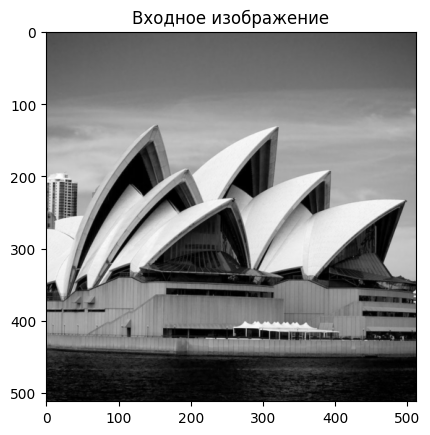

In [43]:
# Чтобы использовать исходную картинку, раскомментируйте:
input_img = content_img.clone()

# Чтобы использовать шум
#input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Входное изображение')

## Оптимизация (градиентный спуск)

Как [предлагал](https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq) _Leon Gatys_, автор алгоритма, который мы реализуем, для оптимизации лучше использовать [L-BFGS](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%91%D1%80%D0%BE%D0%B9%D0%B4%D0%B5%D0%BD%D0%B0_%E2%80%94_%D0%A4%D0%BB%D0%B5%D1%82%D1%87%D0%B5%D1%80%D0%B0_%E2%80%94_%D0%93%D0%BE%D0%BB%D1%8C%D0%B4%D1%84%D0%B0%D1%80%D0%B1%D0%B0_%E2%80%94_%D0%A8%D0%B0%D0%BD%D0%BD%D0%BE). В обучении нейросетей очень часто используется алгоритм `Adam`, и в этой задаче он будет требовать меньше ресурсов, но работать будет немного хуже. Остальные алгоритмы решают эту задачу слишком долго или нестабильно ([ссылка](https://blog.slavv.com/picking-an-optimizer-for-style-transfer-86e7b8cba84b)).

Так что создадим объект-оптимизатор L-BFGS при помощи команды PyTorch ``optim.LBFGS`` и привяжем его к объекту, в котором лежит наше изображение. Оптимизатор будет сдвигать параметры изображения (яркость каждого пикселя по каждому каналу) пока целевая функция будет падать.

In [44]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

Теперь, сердце алгоритма. Мы будем прогонять через нейросеть рабочую версию входного изображения, с каждой итерацией находя значение целевой функции. Затем при помощи фунции ``backward`` будем находить их градиенты (как они поменялись с прошлой итерации?). Оптимизатору нужна функция “closure” которая рассчитывает лосс, каждый раз на новой версии изображения.

Одно последнее ограничение алгоритма. Поскольку сеть оптимизирует численные параметры, мы вполне можем получить числа за пределом диапазона от 0 до 1. Поэтому после обновления рабочего изображения, мы скорректируем все его параметры, обрезав их значения до диапазона от 0 до 1, и так на каждой итерации.

In [45]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    
    print('Построение модели переноса стиля..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # Укажем, какой объект мы будем оптимизировать (включить параметр requires_grad fields)
    input_img.requires_grad_(True)
    # Переключим модель в режим исполнения, чтобы заморозить слои вроде dropout или батч нормализации normalization layers 
    model.eval()
    # Очевидно, мы не будем оптимизировать модель, так что заморозим все параметры
    model.requires_grad_(False)
    
    optimizer = get_input_optimizer(input_img)
    
    print('Оптимизируем картинку..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # скорректируем значения входного изображения
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad() # обнуляем градиенты (иногда их используют между итерациями, но не сейчас)
            model(input_img) # знакомая вам функция, отправить картинку в модель

            # Посчитаем расхождение изображений по стилю и содержимому
            style_score = 0
            content_score = 0

            for sl in style_losses: style_score += sl.loss
            for cl in content_losses: content_score += cl.loss

            style_score *= style_weight # Домножаем каждую компоненту лосса на заданный вес
            content_score *= content_weight

            loss = style_score + content_score
            # И по этому значению осуществляем обратное распространение ошибки (обратно по сети, вплоть до изображения)
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # и в последний раз вернем изображение в диапазон
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Наконец, нам есть что запустить

Построение модели переноса стиля..
Оптимизируем картинку..
run [50]:
Style Loss : 184.734375 Content Loss: 14.339866

run [100]:
Style Loss : 90.041695 Content Loss: 15.986601

run [150]:
Style Loss : 61.500832 Content Loss: 16.588154

run [200]:
Style Loss : 48.007687 Content Loss: 16.699213

run [250]:
Style Loss : 39.421246 Content Loss: 16.527849

run [300]:
Style Loss : 38.390789 Content Loss: 16.316174



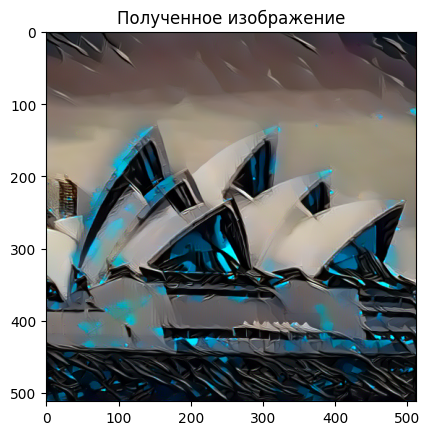

In [46]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Полученное изображение')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

## Библиография

[Image Stylization: History and Future (Part 1)](https://research.adobe.com/news/image-stylization-history-and-future/), Adobe Research 2018

[Intro | Neural Style Transfer #1](https://www.youtube.com/watch?v=S78LQebx6jo), [Basic Theory | Neural Style Transfer #2](https://www.youtube.com/watch?v=B22nIUhXo4E&t=199s)...

[Neural Transfer Using PyTorch](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)

NST на tensorflow: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb

[Visualizing Feature Maps using PyTorch](https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573)